In [1]:
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as albu
import gc

In [2]:
DATA_DIR = "/home/emily/Schreibtisch/BA/PNG/splitted"

x_train_dir = os.path.join(DATA_DIR, 'train', "img")
y_train_dir = os.path.join(DATA_DIR, 'train', "mask")

x_valid_dir = os.path.join(DATA_DIR, 'valid', "img")
y_valid_dir = os.path.join(DATA_DIR, 'valid', "mask")

x_test_dir = os.path.join(DATA_DIR, 'test', "img")
y_test_dir = os.path.join(DATA_DIR, 'test', "mask")

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ["himmel", "strand", "wasser", "unlabelled"] #class_value 0 = himmel
    look_up = {
        0: 76,
        1: 149,
        2: 29,
        3:0
    }
    #CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
    #           'tree', 'signsymbol', 'fence', 'car',
    #           'pedestrian', 'bicyclist', 'unlabelled']


    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        print(self.images_fps)

        # convert str names to class values on masks
        try:
            self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        except TypeError:
            self.class_values = [0,1,2]
        for idx, val in enumerate(self.class_values):
            self.class_values[idx] = self.look_up[val]


        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

In [5]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['himmel'])

['/home/emily/Schreibtisch/BA/PNG/splitted/train/img/30.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/28.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/6.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/32.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/38.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/35.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/24.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/54.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/19.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/23.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/43.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/9.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/26.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/31.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/13.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/3.png', '/home/emily/Schreibtisch/

[0.]


TypeError: Invalid shape () for image data

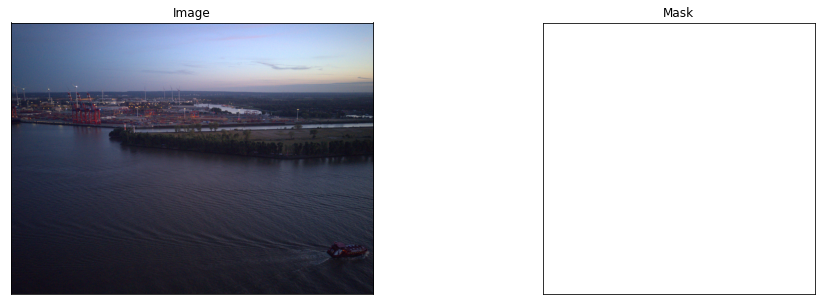

In [8]:
image, mask = dataset[4]  # get some sample
print(mask)
visualize(
    image=image,
    mask=mask.squeeze(),
)

In [6]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(3008, 4000)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/home/emily/anaconda3/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/home/emily/anaconda3/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/home/emily/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/emily/anaconda3/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/ho

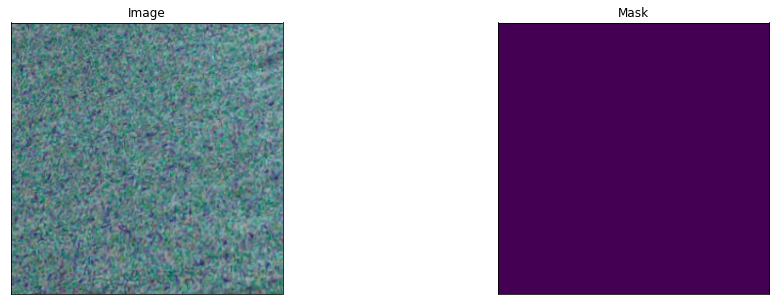

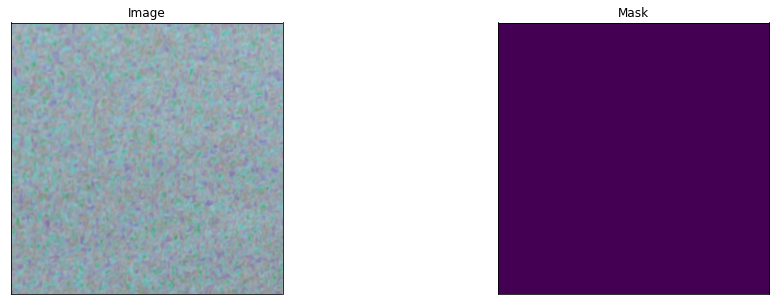

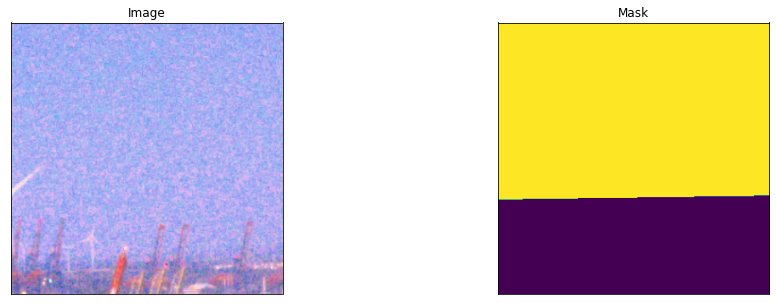

In [8]:
augmented_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=["himmel"]
)
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

Modell Prep

In [7]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [8]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ["himmel"]
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cpu'

In [9]:
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [12]:

train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    #augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

['/home/emily/Schreibtisch/BA/PNG/splitted/train/img/30.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/28.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/6.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/32.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/38.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/35.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/24.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/54.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/19.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/23.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/43.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/9.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/26.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/31.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/13.png', '/home/emily/Schreibtisch/BA/PNG/splitted/train/img/3.png', '/home/emily/Schreibtisch/

/home/emily/anaconda3/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning:

IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead

/home/emily/anaconda3/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning:

This IAAPerspective is deprecated. Please use Perspective instead

/home/emily/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1744: FutureWarning:

This class has been deprecated. Please use RandomBrightnessContrast

/home/emily/anaconda3/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning:

IAASharpen is deprecated. Please use Sharpen instead

/home/emily/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1770: FutureWarning:

This class has been deprecated. Please use RandomBrightnessContrast



Manuell

In [43]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [44]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
max_score = 0

for i in range(0, 1):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/32 [00:00<?, ?it/s]

/home/emily/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


valid:   0%|          | 0/11 [00:00<?, ?it/s]

Catalyst

In [10]:
import torch
import torch.nn as nn
from catalyst.dl import SupervisedRunner

In [13]:
num_epochs = 10  # change me
logdir = "./logs/segmentation_notebook"
loaders = {
    "train": train_loader,
    "valid": valid_loader
}

In [14]:
criterion = smp.utils.losses.DiceLoss()
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4},

    # decrease lr for encoder in order not to permute
    # pre-trained weights with large gradients on training start
    {'params': model.encoder.parameters(), 'lr': 1e-6},
])
scheduler = None

In [15]:
runner = SupervisedRunner()

In [30]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

1/10 * Epoch (train):   0%|          | 0/8 [00:00<?, ?it/s]

Keyboard Interrupt


KeyboardInterrupt: 

In [16]:
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)
test_dataloader = DataLoader(test_dataset)

['/home/emily/Schreibtisch/BA/PNG/splitted/test/img/img_test_4.png', '/home/emily/Schreibtisch/BA/PNG/splitted/test/img/img_test_20.png', '/home/emily/Schreibtisch/BA/PNG/splitted/test/img/img_test_5.png', '/home/emily/Schreibtisch/BA/PNG/splitted/test/img/img_test_8.png', '/home/emily/Schreibtisch/BA/PNG/splitted/test/img/img_test_2.png', '/home/emily/Schreibtisch/BA/PNG/splitted/test/img/img_test_6.png', '/home/emily/Schreibtisch/BA/PNG/splitted/test/img/img_test_9.png', '/home/emily/Schreibtisch/BA/PNG/splitted/test/img/img_test_11.png', '/home/emily/Schreibtisch/BA/PNG/splitted/test/img/img_test_19.png', '/home/emily/Schreibtisch/BA/PNG/splitted/test/img/img_test_10.png', '/home/emily/Schreibtisch/BA/PNG/splitted/test/img/img_test_3.png', '/home/emily/Schreibtisch/BA/PNG/splitted/test/img/img_test_0.png', '/home/emily/Schreibtisch/BA/PNG/splitted/test/img/img_test_13.png', '/home/emily/Schreibtisch/BA/PNG/splitted/test/img/img_test_12.png', '/home/emily/Schreibtisch/BA/PNG/splitted

In [19]:
import collections
from catalyst.dl.callbacks import InferCallback, CheckpointCallback
loaders = {"infer": test_dataloader}
runner.infer(
    model=model,
    loaders=loaders,
    callbacks=[
        CheckpointCallback(
            resume="/home/emily/Downloads/best.pth"),
        InferCallback()
    ],
)

=> loading checkpoint /home/emily/Downloads/best.pth


KeyError: 'epoch'